# System Outline

1. Keyword bidding
2. Keyword allocation

## Steps

- Select or simulate a campaign with 5 keywords and a daily budget
- **Create a Baseline Utility Model (Direct Method - DM)**
    - Use the historical data to build a baseline utility model. This model predicts the expected value (utility) for different bid amounts.
    - The utility is install/$ --> maximize the number of installs I get per dollar spent
    - Meaning i need to predict the install/$ for differnt spend levels
    - I need to estimate the expected taps per spend
- Logged policy
    - historical bids and their outcomes
- Learned policy
    - RL agent the decides the bid

given the bid selected, estimate the utility (based on the utility + spend model)

# Relationship between bid and utility 

In [385]:
from asa_simulation.data import get_data, clean_data
from asa_simulation.preprocessor import preprocess


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


In [18]:
print("Fetching keyword data")
start_date = "2023-08-01"
end_date = "2023-10-01"

market = "('US', 'GB', 'DE', 'CA', 'JP', 'MX', 'FR', 'SE', 'CH', 'NL')"
df_market = get_data(start_date=start_date, end_date=end_date, dataset_id="adobe", market=market)
df_market_clean = clean_data(df_market, start_date=start_date, end_date=end_date)

Fetching keyword data

Load data from local CSV...


/Users/moe/code/mabuhalala/AI/asa_simulation/asa_simulation/data.py:22: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cache_path)


✅ Data loaded, with shape (3952862, 35)

Clean data...

Load data from local CSV...
✅ Data cleaned, with shape (3264937, 20)


In [461]:
df_us = df_market_clean[
               (df_market_clean["country_or_region"] == "US")]

In [463]:
df_us["no_impressions"] = df_us["impressions"].apply(lambda x: 1 if x == 0 else 0)



In [467]:
nr_impressions = df_us.groupby(["keyword_id"]).agg({"date": "count", "no_impressions": "sum"})


nr_impressions["prct_no_imp"] = nr_impressions["no_impressions"] / nr_impressions["date"] * 100

In [469]:
nr_impressions["prct_no_imp"]

100.000000    9454
98.305085      143
96.610169       61
45.762712       46
94.915254       36
              ... 
75.862069        1
37.931034        1
30.508475        1
13.559322        1
72.222222        1
Name: prct_no_imp, Length: 106, dtype: int64

In [471]:
px.histogram(nr_impressions["prct_no_imp"], histnorm="percent")

In [457]:
df_market_clean[(df_market_clean["impressions"] == 0) &
               (df_market_clean["country_or_region"] == "US")].shape

(592322, 20)

In [458]:
592322/606534

0.97656850234282

In [570]:
df_market_clean.columns

Index(['date', 'campaign_id', 'campaign_name', 'ad_group_id', 'ad_group_name',
       'keyword_id', 'keyword', 'country_or_region', 'match_type',
       'share_of_voice', 'daily_budget', 'keyword_status', 'bid', 'ttr',
       'taps', 'local_spend', 'impressions', 'installs', 'avg_cpt', 'avg_cpa'],
      dtype='object')

In [386]:
df_clusters = preprocess(df_market_clean)


/Users/moe/code/mabuhalala/AI/asa_simulation/asa_simulation/preprocessor.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/moe/code/mabuhalala/AI/asa_simulation/asa_simulation/preprocessor.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [438]:
df_clusters.tail()

,date,keyword_id,keyword,share_of_voice,bid,taps,local_spend,impressions,installs,cpi,cpt,ttr,cvr,cluster,cluster_name
3264886,2023-09-28,1458151896,logo,0.6,3.3,2.0,6.5175,31.0,0.0,0.0000,3.258750,0.064516,0.000000,6,LP_VLC
3264890,2023-09-28,1458151900,pic collage maker,0.6,4.4,1.0,4.3695,17.0,0.0,0.0000,4.369500,0.058824,0.000000,6,LP_VLC
3264891,2023-09-28,1458154141,editor,0.6,4.4,2.0,6.1754,36.0,2.0,3.0877,3.087700,0.055556,1.000000,3,LP_MC
3264894,2023-09-28,1458154144,photo editor,0.6,4.4,1.0,3.9272,23.0,0.0,0.0000,3.927200,0.043478,0.000000,6,LP_VLC
3264895,2023-09-28,1458154145,sticker maker,0.6,4.4,3.0,13.0471,44.0,1.0,13.0471,4.349033,0.068182,0.333333,2,LP_HC


In [388]:
df_clusters["cluster_name"].unique()

array(['LP_VLC', 'HP_LC', 'MP_LC', 'LP_HC', 'LP_MC', 'MP_MC', 'VLP_VHC'],
      dtype=object)

In [443]:
df_mp_mc = df_clusters[df_clusters["cluster_name"]=="MP_MC"]
df_hp_lc = df_clusters[df_clusters["cluster_name"]=="HP_LC"]
df_lp_mc = df_clusters[df_clusters["cluster_name"]=="LP_MC"]
df_lp_hc = df_clusters[df_clusters["cluster_name"]=="LP_HC"]

df_ps = df_mp_mc[df_mp_mc["keyword"]=="ps"]

In [415]:
px.scatter(data_frame=df_hp_lc, x="bid", y="impressions")

In [444]:
df_lp_hc

,date,keyword_id,keyword,share_of_voice,bid,taps,local_spend,impressions,installs,cpi,cpt,ttr,cvr,cluster,cluster_name
9989,2023-08-01,216466417,Instagram,0.60,3.40,6.0,16.5448,409.0,1.0,16.544800,2.757467,0.014670,0.166667,2,LP_HC
13029,2023-08-01,256891945,snapseed,0.05,2.40,4.0,9.3824,42.0,1.0,9.382400,2.345600,0.095238,0.250000,2,LP_HC
13709,2023-08-01,402439999,editing app,0.60,1.87,4.0,7.3577,30.0,1.0,7.357700,1.839425,0.133333,0.250000,2,LP_HC
21080,2023-08-01,435649538,pdf convert,0.60,4.76,2.0,8.2989,36.0,1.0,8.298900,4.149450,0.055556,0.500000,2,LP_HC
30240,2023-08-01,1077893590,after effects,0.15,0.85,18.0,14.9956,248.0,2.0,7.497800,0.833089,0.072581,0.111111,2,LP_HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208635,2023-09-27,1458150948,pdf & scanner,0.60,6.50,8.0,24.1447,35.0,2.0,12.072350,3.018088,0.228571,0.250000,2,LP_HC
3264556,2023-09-28,1454470043,pdf editor,0.60,8.00,5.0,35.5320,24.0,3.0,11.844000,7.106400,0.208333,0.600000,2,LP_HC
3264561,2023-09-28,1454470048,scanner app free,0.60,10.50,15.0,131.4792,37.0,13.0,10.113785,8.765280,0.405405,0.866667,2,LP_HC
3264880,2023-09-28,1458151890,flyer maker,0.60,4.95,4.0,14.3087,25.0,2.0,7.154350,3.577175,0.160000,0.500000,2,LP_HC


In [450]:
df_test = df_clusters[df_clusters["keyword_id"]==256888851]

In [452]:
px.scatter(data_frame=df_test, x="local_spend", y="installs")

# Estimating ROI per spend/bid

In [403]:
# Hill function

Parameters: [9.01588861e+01 1.63019737e+00 9.08510413e-07]
RMSE: 115.41254043932356
R-squared: -3.1519231669108194e-12



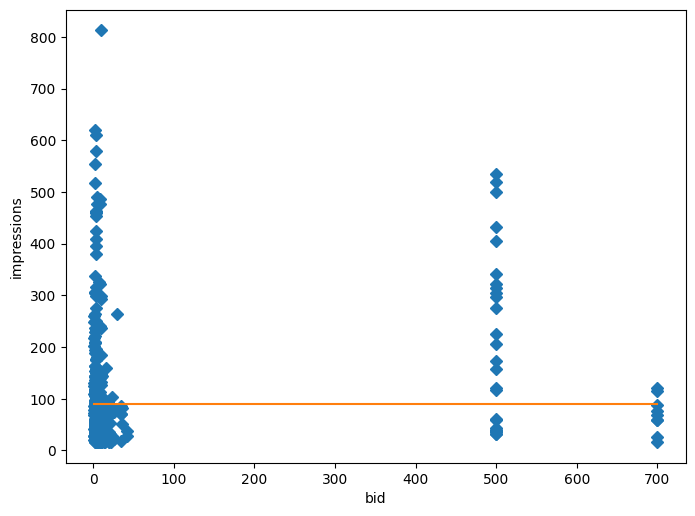

In [569]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings


df = df_lp_hv.copy()

df["roi"] = df["installs"] / df["local_spend"]
df["roi"] = df["roi"].replace([np.inf, -np.inf], 0)
df["roi"].fillna(0, inplace=True)

# Split data (for simplicity, let's just use all data for fitting)
feature = "bid"
target = "impressions"

x_data = df[feature]
y_data = df[target]

# rename data for simpler code re-use later
xData = x_data
yData = y_data


def func(x, a, b, c): # Hill sigmoidal equation from zunzun.com
    return  a * numpy.power(x, b) / (numpy.power(c, b) + numpy.power(x, b)) 


# these are the same as the scipy defaults
initialParameters = numpy.array([1.0, 1.0, 1.0])

# do not print unnecessary warnings during curve_fit()
warnings.filterwarnings("ignore")

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, initialParameters, maxfev=10000)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

print('Parameters:', fittedParameters)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

print()


##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel(feature) # X axis data label
    axes.set_ylabel(target) # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

Parameters: [3.13258303e-01 5.01333611e-01 5.64705851e-12]
RMSE: 0.08992264453059791
R-squared: -1.6703605387746734e-07



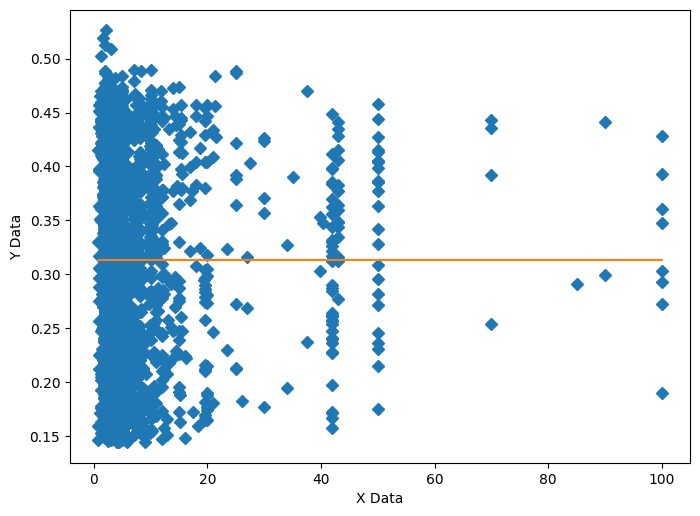

In [419]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings


bdf = df_lp_mc.copy()

df["roi"] = df["installs"] / df["local_spend"]
df["roi"] = df["roi"].replace([np.inf, -np.inf], 0)
df["roi"].fillna(0, inplace=True)

# Split data (for simplicity, let's just use all data for fitting)
feature = "bid"

x_data = df[feature]
y_data = df['roi']

# rename data for simpler code re-use later
xData = x_data
yData = y_data


def func(x, a, b, c): # Hill sigmoidal equation from zunzun.com
    return  a * numpy.power(x, b) / (numpy.power(c, b) + numpy.power(x, b)) 


# these are the same as the scipy defaults
initialParameters = numpy.array([1.0, 1.0, 1.0])

# do not print unnecessary warnings during curve_fit()
warnings.filterwarnings("ignore")

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, initialParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

print('Parameters:', fittedParameters)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

print()


##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

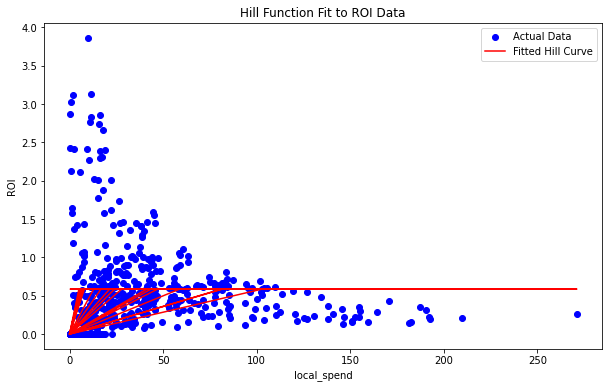

Parameters of the Hill function:
ROI_max: 0.5992, K: 0.0000, h: 0.0054


In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Hill function
def hill(spend, ROI_max, K, h):
    return ROI_max * spend**h / (K**h + spend**h)


df = df_mp_mc.copy()

df["roi"] = df["installs"] / df["local_spend"]
df["roi"] = df["roi"].replace([np.inf, -np.inf], 0)
df["roi"].fillna(0, inplace=True)

# Split data (for simplicity, let's just use all data for fitting)
feature = "local_spend"
x_data = df[feature]
y_data = df['roi']

# Fit the data using the Hill function
params, covariance = curve_fit(hill, x_data, y_data, maxfev=100000)

# Predicted ROI
df['predicted_roi'] = hill(df[feature], *params)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df[feature], df['roi'], label='Actual Data', color='blue')
plt.plot(df[feature], df['predicted_roi'], label='Fitted Hill Curve', color='red')
plt.title('Hill Function Fit to ROI Data')
plt.xlabel(feature)
plt.ylabel('ROI')
plt.legend()
plt.show()

print(f"Parameters of the Hill function:\nROI_max: {params[0]:.4f}, K: {params[1]:.4f}, h: {params[2]:.4f}")



In [410]:
df

,date,keyword_id,keyword,share_of_voice,bid,taps,local_spend,impressions,installs,cpi,cpt,ttr,cvr,cluster,cluster_name,roi,predicted_roi
16872,2023-08-01,424446880,ps,0.95,10.94,53.0,17.3107,655.0,40.0,0.432768,0.326617,0.080916,0.754717,4,MP_MC,2.310710,1.675158
71555,2023-08-02,424446880,ps,0.95,10.94,52.0,18.1163,573.0,34.0,0.532832,0.348390,0.090750,0.653846,4,MP_MC,1.876763,1.675158
126238,2023-08-03,424446880,ps,0.95,10.94,42.0,15.2098,594.0,27.0,0.563326,0.362138,0.070707,0.642857,4,MP_MC,1.775171,1.675158
180921,2023-08-04,424446880,ps,0.95,10.94,56.0,10.0813,501.0,39.0,0.258495,0.180023,0.111776,0.696429,4,MP_MC,3.868549,1.675158
235598,2023-08-05,424446880,ps,0.95,30.00,56.0,16.1051,577.0,37.0,0.435273,0.287591,0.097054,0.660714,4,MP_MC,2.297409,1.675158
290291,2023-08-06,424446880,ps,0.95,30.00,48.0,12.8202,688.0,26.0,0.493085,0.267087,0.069767,0.541667,4,MP_MC,2.028049,1.675158
344847,2023-08-07,424446880,ps,0.95,30.00,54.0,11.6323,599.0,33.0,0.352494,0.215413,0.090150,0.611111,4,MP_MC,2.836928,1.675158
399406,2023-08-08,424446880,ps,0.95,30.00,42.0,18.3744,688.0,29.0,0.633600,0.437486,0.061047,0.690476,4,MP_MC,1.578283,1.675158
454123,2023-08-09,424446880,ps,0.95,30.00,49.0,15.4145,740.0,31.0,0.497242,0.314582,0.066216,0.632653,4,MP_MC,2.011093,1.675158
508840,2023-08-10,424446880,ps,0.95,30.00,46.0,31.0637,801.0,28.0,1.109418,0.675298,0.057428,0.608696,4,MP_MC,0.901374,1.675158


# Tests with Turnbull to estimate competitor bids

In [2]:
intervals = [
    [1.50, 2.50],  # we bid $1.49 and lost; we bid $2.51 and won
    [2.00, 3.00],
    [2.75, 3.75],
    [3.50, 4.50]
]

In [4]:
import numpy as np

def turnbull_algorithm(intervals, max_iterations=1000, tolerance=1e-6):
    # Convert intervals to discrete integer intervals
    unique_values = sorted(list({v for interval in intervals for v in interval}))
    value_to_index = {value: index for index, value in enumerate(unique_values)}
    
    indexed_intervals = [(value_to_index[start], value_to_index[end]) for start, end in intervals]
    
    # Initialize weights
    n = len(unique_values)
    weights = np.zeros(n)
    for start, end in indexed_intervals:
        weights[start:end+1] += 1.0 / (end - start + 1)
    
    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        old_weights = weights.copy()
        
        # Update weights using conditional probabilities
        for i, (start, end) in enumerate(indexed_intervals):
            cumulative_prob = weights[start:end+1].sum()
            if cumulative_prob > 0:
                weights[start:end+1] = (weights[start:end+1] / cumulative_prob) / len(indexed_intervals)
        
        # Check for convergence
        diff = np.abs(weights - old_weights).sum()
        if diff < tolerance:
            break
    
    return {unique_values[i]: w for i, w in enumerate(weights) if w > 0}

# Estimate the distribution
estimated_distribution = turnbull_algorithm(intervals)

# Output the results
for value, weight in estimated_distribution.items():
    print(f"Value {value:.2f}: Weight {weight:.4f}")


Value 1.50: Weight 0.1145
Value 2.00: Weight 0.0678
Value 2.50: Weight 0.0678
Value 2.75: Weight 0.0572
Value 3.00: Weight 0.0572
Value 3.50: Weight 0.0678
Value 3.75: Weight 0.0678
Value 4.50: Weight 0.1145


In [60]:
import pandas as pd
import numpy as np

# Creating an artificial dataset for 30 days
np.random.seed(42)  # for reproducibility

data = {
    'date': pd.date_range(start='2023-01-01', periods=30, freq='D'),
    'keyword': ['sample_keyword'] * 30,
    'bid': np.random.uniform(1.0, 3.0, 30),
    'impressions': np.random.randint(100, 500, 30),
    'taps': np.random.randint(10, 100, 30),
    'installs': np.random.randint(5, 50, 30)
}
data['avg_cpt'] = data['bid'] / data['taps']
data['avg_cpi'] = data['bid'] / data['installs']

df = pd.DataFrame(data)


In [61]:
avg_spend_per_tap = df['avg_cpt'].mean()
avg_spend_per_tap

0.035762688386359

In [64]:
nominal_step = 0.5

intervals = []
for bid in df['bid']:
    start = bid - nominal_step
    end = bid
    if start < avg_spend_per_tap:
        start = avg_spend_per_tap
    intervals.append((start, end))


In [65]:
intervals

[(1.249080237694725, 1.749080237694725),
 (2.4014286128198323, 2.9014286128198323),
 (1.96398788362281, 2.46398788362281),
 (1.6973169683940732, 2.197316968394073),
 (0.812037280884873, 1.312037280884873),
 (0.8119890406724053, 1.3119890406724053),
 (0.6161672243363989, 1.116167224336399),
 (2.23235229154987, 2.73235229154987),
 (1.7022300234864174, 2.2022300234864174),
 (1.916145155592091, 2.416145155592091),
 (0.5411689885916049, 1.041168988591605),
 (2.4398197043239884, 2.9398197043239884),
 (2.1648852816008435, 2.6648852816008435),
 (0.9246782213565523, 1.4246782213565523),
 (0.8636499344142012, 1.3636499344142012),
 (0.8668090197068676, 1.3668090197068676),
 (1.1084844859190754, 1.6084844859190754),
 (1.549512863264476, 2.049512863264476),
 (1.3638900372842315, 1.8638900372842315),
 (1.0824582803960838, 1.5824582803960838),
 (1.7237057894447592, 2.223705789444759),
 (0.7789877213040837, 1.2789877213040837),
 (1.0842892970704363, 1.5842892970704363),
 (1.2327236865873834, 1.7327236

In [68]:
def turnbull_algorithm(intervals, max_iterations=1000, tolerance=1e-6):
    unique_values = sorted(list({v for interval in intervals for v in interval}))
    value_to_index = {value: index for index, value in enumerate(unique_values)}
    indexed_intervals = [(value_to_index[start], value_to_index[end]) for start, end in intervals]
    
    n = len(unique_values)
    weights = np.zeros(n)
    for start, end in indexed_intervals:
        weights[start:end+1] += 1.0 / (end - start + 1)
    
    for iteration in range(max_iterations):
        old_weights = weights.copy()
        for i, (start, end) in enumerate(indexed_intervals):
            cumulative_prob = weights[start:end+1].sum()
            if cumulative_prob > 0:
                weights[start:end+1] = (weights[start:end+1] / cumulative_prob) / len(indexed_intervals)
        
        diff = np.abs(weights - old_weights).sum()
        if diff < tolerance:
            break
    
    return {unique_values[i]: w for i, w in enumerate(weights) if w > 0}

estimated_distribution = turnbull_algorithm(intervals)


In [69]:
for value, weight in estimated_distribution.items():
    print(f"Estimated bid value: ${value}, Weight: {weight:.4f}")


Estimated bid value: $0.5411689885916049, Weight: 0.0062
Estimated bid value: $0.5929008254399954, Weight: 0.0072
Estimated bid value: $0.6161672243363989, Weight: 0.0037
Estimated bid value: $0.7789877213040837, Weight: 0.0018
Estimated bid value: $0.8119890406724053, Weight: 0.0018
Estimated bid value: $0.812037280884873, Weight: 0.0019
Estimated bid value: $0.8636499344142012, Weight: 0.0031
Estimated bid value: $0.8668090197068676, Weight: 0.0022
Estimated bid value: $0.8993475643167195, Weight: 0.0031
Estimated bid value: $0.9246782213565523, Weight: 0.0012
Estimated bid value: $1.041168988591605, Weight: 0.0012
Estimated bid value: $1.0824582803960838, Weight: 0.0026
Estimated bid value: $1.0842892970704363, Weight: 0.0018
Estimated bid value: $1.0929008254399954, Weight: 0.0018
Estimated bid value: $1.1084844859190754, Weight: 0.0036
Estimated bid value: $1.116167224336399, Weight: 0.0036
Estimated bid value: $1.2327236865873834, Weight: 0.0023
Estimated bid value: $1.2490802376

# other versions

## Step 1: Generate Dummy Data


https://surpyval.readthedocs.io/en/v0.8/surpyval.nonparametric.html

Of course! Let's break down interval censoring in the context of bids, step by step.

### Interval Censoring

At its core, interval censoring means that you only know the event of interest occurred within a certain range (interval) but not exactly when. This contrasts with right censoring, where you know the event did not occur up to a certain time but have no knowledge after that time.

### Bids and Intervals

In the context of bids, imagine you're trying to determine the exact bid amount that would win an auction. Due to the nature of many auction systems, you often don't know the exact winning bid amount—only that it lies within a certain range.

Here's a conceptual example:

- **Scenario 1**: You bid $10, and you didn't win the auction. You later find out the winning bid was somewhere between $10 and $15. Your knowledge of the exact winning bid is interval-censored to be within [$10, $15].
  
- **Scenario 2**: You bid $20, and you won. However, it's possible you could have won with a slightly lower bid, say $19 or $18.50. But you don't know exactly how much lower. Thus, you know the winning bid is in the interval [$18, $20], even though you won with $20.

### How Survival Analysis Treats Intervals

When working with interval-censored data in survival analysis:

- The survival function is adjusted to take into account that the exact event time is not known, only its interval.
  
- For each observation, the model considers that the event could have occurred at any point within the given interval.
  
- Instead of treating events as occurring at exact times (as with non-censored data) or before/after a certain time (as with right-censored data), the model spreads the "probability weight" of the event occurring across the interval.

### Back to Your Code

In the code you provided earlier:

- `left_censored_bids` are the lower bounds of the intervals, and `right_censored_bids` are the upper bounds. For each auction or bid row in your data, you have an associated interval where the actual "winning bid amount" might lie.

- By fitting a Kaplan-Meier estimator with interval censoring, you're estimating the probability of "surviving" (not winning) past a certain bid amount, taking into account all these bid intervals.

- In essence, you're trying to build a curve that shows, for each bid amount, what the likelihood is that you wouldn't win an auction if you bid that amount, using all the interval-censored data you have.

I hope this clarifies the concept of interval censoring in the context of bids and how survival analysis uses this data. The essence is modeling uncertainty in the exact "event time" (in this case, the exact winning bid amount) and using the information that the event lies within a certain range.

In [141]:
# real data
df_adobe.head()

,date,campaign_id,campaign_name,ad_group_id,ad_group_name,keyword_id,keyword,country_or_region,match_type,share_of_voice,...,keyword_status,bid,ttr,taps,local_spend,impressions,installs,avg_cpt,avg_cpa,roa
744,2023-08-01,104407636,NA - Lightroom - iPhone - Brand - Exact,104491648,Brand - Exact,899250539,adobe,US,EXACT,0.35,...,ACTIVE,5.0,0.0636,178,349.2822,2797,111,1.9623,3.1467,0.317795
55427,2023-08-02,104407636,NA - Lightroom - iPhone - Brand - Exact,104491648,Brand - Exact,899250539,adobe,US,EXACT,0.35,...,ACTIVE,5.0,0.0521,140,230.9428,2686,93,1.6496,2.4833,0.402697
110110,2023-08-03,104407636,NA - Lightroom - iPhone - Brand - Exact,104491648,Brand - Exact,899250539,adobe,US,EXACT,0.35,...,ACTIVE,5.0,0.0491,136,261.8621,2770,83,1.9255,3.1550,0.316961
164793,2023-08-04,104407636,NA - Lightroom - iPhone - Brand - Exact,104491648,Brand - Exact,899250539,adobe,US,EXACT,0.25,...,ACTIVE,5.0,0.0567,124,239.2228,2186,76,1.9292,3.1477,0.317695
219476,2023-08-05,104407636,NA - Lightroom - iPhone - Brand - Exact,104491648,Brand - Exact,899250539,adobe,US,EXACT,0.25,...,ACTIVE,5.0,0.0780,116,245.8743,1488,71,2.1196,3.4630,0.288765


In [426]:
df_adobe.columns

Index(['date', 'campaign_id', 'campaign_name', 'ad_group_id', 'ad_group_name',
       'keyword_id', 'keyword', 'country_or_region', 'match_type',
       'share_of_voice', 'daily_budget', 'keyword_status', 'bid', 'ttr',
       'taps', 'local_spend', 'impressions', 'installs', 'avg_cpt', 'avg_cpa',
       'roa', 'roi'],
      dtype='object')

In [427]:
df_adobe[['date', 'campaign_id', 'ad_group_id', 
       'keyword_id', 'bid', 'local_spend', 'impressions', 'taps', 'installs']]

,date,campaign_id,ad_group_id,keyword_id,bid,local_spend,impressions,taps,installs
91,2023-08-01,10817664,1172895461,1172890540,10.01,0.0000,0,0,0
97,2023-08-01,10817664,1214155430,1215643766,13.65,0.0000,0,0,0
103,2023-08-01,10817664,1244562376,1244570302,22.75,106.3199,555,93,67
692,2023-08-01,24919283,24915574,93135106,10.00,0.0000,0,0,0
744,2023-08-01,104407636,104491648,899250539,5.00,349.2822,2797,178,111
...,...,...,...,...,...,...,...,...,...
3242693,2023-09-28,1035805957,1036218981,1036219032,6.75,0.0000,0,0,0
3262156,2023-09-28,1290555613,1290555624,1290563209,67.84,0.0000,0,0,0
3263056,2023-09-28,1328274426,1329473211,1331539367,4.00,0.0000,0,0,0
3263062,2023-09-28,1328274426,1329644128,1331546370,15.90,1.7676,51,4,1


In [142]:
df_adobe.shape

(59, 21)

## Step 2: Transform Data to Resemble Interval-Censored Data


I'll make a simplistic assumption: If impressions are zero, then it's left-censored (we didn't win the bid). If impressions are maximum (let's assume 1000 for simplicity), it's right-censored (we likely outbid everyone, but don't know by how much).

In [326]:
df

,date,campaign_id,campaign_name,ad_group_id,ad_group_name,keyword_id,keyword,country_or_region,match_type,share_of_voice,daily_budget,keyword_status,bid,ttr,taps,local_spend,impressions,installs,avg_cpt,avg_cpa
91,2023-08-01,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1172895461,Baby Proof,1172890540,adobe,US,EXACT,0.25,156.0,ACTIVE,10.01,0.0000,0,0.0000,0,0,NaN,0.0000
97,2023-08-01,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1214155430,Landscape,1215643766,adobe,US,EXACT,0.25,156.0,ACTIVE,13.65,0.0000,0,0.0000,0,0,NaN,0.0000
103,2023-08-01,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1244562376,CPP Q1,1244570302,adobe,US,EXACT,0.25,156.0,ACTIVE,22.75,0.1676,93,106.3199,555,67,1.143225,1.5869
692,2023-08-01,24919283,NA_SCAN_BRAND_GENERAL_APPLE_EN,24915574,NA Adobe Scan Brand Exact,93135106,adobe,US,EXACT,0.60,125.0,ACTIVE,10.00,0.0000,0,0.0000,0,0,NaN,0.0000
744,2023-08-01,104407636,NA - Lightroom - iPhone - Brand - Exact,104491648,Brand - Exact,899250539,adobe,US,EXACT,0.35,667.0,ACTIVE,5.00,0.0636,178,349.2822,2797,111,1.962260,3.1467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3242693,2023-09-28,1035805957,NA - Lightroom - iPhone - Brand - Broad,1036218981,Brand - Exact,1036219032,adobe,US,EXACT,0.60,100.0,ACTIVE,6.75,0.0000,0,0.0000,0,0,NaN,0.0000
3262156,2023-09-28,1290555613,US - Spark Post - Top Brand - Apple - Exact,1290555624,Adobe,1290563209,adobe,US,EXACT,0.60,2500.0,ACTIVE,67.84,0.0000,0,0.0000,0,0,NaN,0.0000
3263056,2023-09-28,1328274426,NA_READER_BRAND_GENERAL_APPLE_EN_iPad,1329473211,Landscape,1331539367,adobe,US,EXACT,0.60,730.0,ACTIVE,4.00,0.0000,0,0.0000,0,0,NaN,0.0000
3263062,2023-09-28,1328274426,NA_READER_BRAND_GENERAL_APPLE_EN_iPad,1329644128,CPP Q1,1331546370,adobe,US,EXACT,0.60,730.0,ACTIVE,15.90,0.0784,4,1.7676,51,1,0.441900,1.7676


In [545]:
df = df_adobe.copy()

In [546]:
df["avg_cpt"] = df["local_spend"]  / df["taps"]

In [480]:
avg_impressions = df["impressions"].mean()
avg_cpt = df["avg_cpt"].mean()

In [542]:
left_censored_bids = []
right_censored_bids = []

for index, row in df.iterrows():
    bid = row['bid']
    impressions = row['impressions']
    taps = row['taps']
    avg_impressions = df[df["bid"] == bid]["impressions"].mean()
    
    
    if taps == 0:
        avg_cpt = df[df["bid"] == bid]["avg_cpt"].mean()
        if np.isnan(avg_cpt):
            avg_cpt = bid
        
    else:
        avg_cpt = row["avg_cpt"]
        
        
    
    if impressions < avg_impressions:  # Assuming we did not win all bids

        left_censored_bids.append(bid)
        right_censored_bids.append(np.inf)  # Infinite, because we don't know the upper bound
        
    elif impressions >= avg_impressions:
        # the left bound can't be higher than the right bound
        # we can't use inf in the left bound due to the method we want to use
        
        if avg_cpt > bid:
            left_censored_bids.append(bid)
            right_censored_bids.append(bid)

        else:
            left_censored_bids.append(avg_cpt)
            right_censored_bids.append(bid)
        


# Convert to numpy arrays
left_censored_bids = np.array(left_censored_bids)
right_censored_bids = np.array(right_censored_bids)


[12. 18. 28.]
[ 8. 22. 32.]


In [549]:
import numpy as np
import pandas as pd

def get_censored_intervals(df):
    left_censored_bids = []
    right_censored_bids = []

    # Precompute the median values
    median_impressions_per_bid = df.groupby('bid')['impressions'].median()
    median_cpt = df.groupby('bid')['avg_cpt'].median()

    for index, row in df.iterrows():
        bid = row['bid']
        impressions = row['impressions']
        taps = row['taps']

        # Get the median impressions for the current bid
        avg_impressions = median_impressions_per_bid.get(bid, 0)

        # Determine avg_cpt based on taps
        if taps == 0:
            avg_cpt = median_cpt.get(bid, bid)  # Default to bid if no median value exists
            
            if np.isnan(avg_cpt):
                avg_cpt = bid

        else:
            avg_cpt = row["avg_cpt"]

        # Determine bid range based on difference from avg_cpt
        bid_range = bid - avg_cpt

        # Logic for deciding the left and right censored bounds
        if impressions < avg_impressions:  # Assuming we did not win all bids
            left_censored_bids.append(bid)
            right_censored_bids.append(np.inf)  # Infinite, as we don't know the upper bound
        
        else:  # For cases where impressions >= avg_impressions
            left_bound = max(bid - bid_range, 0)  # Ensure left bound is non-negative
            right_bound = bid + bid_range
            
            left_censored_bids.append(left_bound)
            right_censored_bids.append(right_bound)

    # Convert lists to numpy arrays
    left_censored_bids = np.array(left_censored_bids)
    right_censored_bids = np.array(right_censored_bids)

    return left_censored_bids, right_censored_bids



left, right = get_censored_intervals(df)

[        nan         nan 22.75               nan  1.96225955  1.48818704
         nan         nan         nan         nan         nan  1.28325981
 19.68        1.3111673          nan         nan  1.04446238         nan
  1.64959143  1.29791628         nan         nan         nan         nan
         nan  1.28325981 19.68        1.3111673          nan         nan
  1.16125408         nan  1.92545662  1.30960606         nan         nan
         nan         nan         nan  1.28325981 19.68        1.3111673
         nan         nan 22.75               nan  5.          1.29258
         nan         nan         nan         nan         nan  1.28325981
 19.68        1.3111673          nan         nan  1.14298778         nan
  5.          1.61665122         nan         nan         nan         nan
         nan  1.28325981 19.68        1.3111673          nan         nan
  0.94200481         nan  5.          1.23112581         nan         nan
         nan         nan         nan  1.28325981  0.909

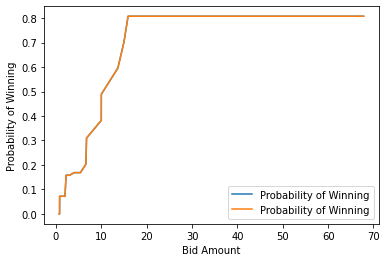

In [540]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit_interval_censoring(lower_bound=left_censored_bids,
                           upper_bound=right_censored_bids)

# Calculate the probability of winning
winning_probability = 1 - kmf.survival_function_

# Plot
plt.plot(winning_probability,
         label='Probability of Winning')

plt.ylabel('Probability of Winning')
plt.xlabel('Bid Amount')
plt.legend()
plt.show()

The survival function gives you the probability of "surviving" (i.e., not winning the bid) past a given bid amount. 


Given the construction of the survival analysis using the provided Python code, the win rate signifies the probability of winning a single bid for a specific bid amount. Here's the reasoning:

Interval Construction: The intervals were constructed based on the difference between individual bids and their average/median cost per tap (avg_cpt). These intervals essentially represent a range within which the true winning bid might lie for that particular row of data.

Impressions-based Logic: The logic uses average (or median) impressions to determine if you won or lost more bids than average for a given bid amount. When impressions < avg_impressions, the assumption is that you didn't win all bids at that bid amount, and vice versa. However, the exact proportion of bids won is not directly determined, only a probable range based on the average.

Survival Curve Interpretation: When you plot the survival curve, it gives you the probability of "surviving" or not winning the bid past a given bid amount. This is essentially telling you the probability of winning a single bid at that bid amount, not the average number of bids.

However, it's worth noting that while the win rate signifies the probability of winning a single bid, it's informed by the aggregate behavior of all bids at that bid amount (due to using average/median values in the logic). Therefore, the survival curve does encapsulate the average behavior of bids, but the win rate for a specific bid amount reflects the probability of winning a single bid at that amount.



Estimating daily spend given a bid requires a few more pieces of information:

1. **Win Rate (Probability of Winning a Bid)**:
   - As discussed earlier, you can use the survival curve to determine the probability of winning a bid at a given bid amount. Let's call this \( P_{win} \).

2. **Total Auctions Available (Per Day)**:
   - You need to know the total number of auctions (or bidding opportunities) available for that keyword per day. Let's call this \( A_{day} \).

3. **Expected Daily Impressions**:
   - \( Impressions_{day} = P_{win} \times A_{day} \)

4. **Click-Through Rate (CTR)**:
   - If you have historical data or industry benchmarks, determine the CTR for your ad. Let's call this \( CTR \).

5. **Cost-Per-Click (CPC) or Cost-Per-Impression**:
   - Depending on your bidding strategy, you might be charged per click or per impression. Given a bid, the actual cost might be lower if the ad platform uses a second-price auction system (you pay just above the second-highest bid). But to simplify, we'll assume you pay the bid amount for each click or impression.

6. **Estimated Daily Clicks**:
   - \( Clicks_{day} = Impressions_{day} \times CTR \)

Now, based on your billing model:

- **For Cost-Per-Click (CPC) Model**:
  \[ Spend_{day\_CPC} = Clicks_{day} \times bid \]

- **For Cost-Per-Impression (CPM) Model**:
  - Typically, in CPM, you're charged for every thousand impressions.
  \[ Spend_{day\_CPM} = \left( \frac{Impressions_{day}}{1000} \right) \times bid \]

Remember that these are estimations. The actual daily spend can vary based on competition, quality score (in platforms like Google Ads), and other external factors. Always monitor your actual spend and adjust your estimates as needed.

In [566]:
1 - kmf.predict(15)

NPMLE_estimate_upper    0.702449
NPMLE_estimate_lower    0.702449
Name: 15, dtype: float64

In [495]:
left_censored_bids.max(), left_censored_bids.min()

(67.84, 0.7208547683923705)

In [496]:
right_censored_bids.max(), right_censored_bids.min()

(inf, 2.0)

In [492]:
len(left_censored_bids)

825

In [493]:
len(right_censored_bids)

825

## Step 3: Apply Turnbull Method using Lifelines


In [500]:
import surpyval as surv
from surpyval import Turnbull as TB
from matplotlib import pyplot as plt

# Convert data to the format required for surpyval
x = np.array([left_censored_bids, right_censored_bids]).T

# Fit the Turnbull model
model = TB.fit(x=x, turnbull_estimator='Nelson-Aalen')

# Plotting


In [501]:
len( left_censored_bids)

825

In [502]:
len(model.R)

206

In [503]:
model.r

array([825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.        ,
       825.        , 825.        , 825.        , 825.  

In [504]:
model.x

array([ 0.72085477,  0.73793333,  0.74521538,  0.75391923,  0.75587618,
        0.76255   ,  0.76786437,  0.76885604,  0.77364534,  0.78815122,
        0.79061622,  0.79202288,  0.79337441,  0.7996862 ,  0.8       ,
        0.8031164 ,  0.80651875,  0.80710446,  0.80839785,  0.81023325,
        0.81100172,  0.81117984,  0.81255425,  0.81744443,  0.82294801,
        0.83003565,  0.83594487,  0.83755166,  0.84128114,  0.84589583,
        0.846925  ,  0.848175  ,  0.84989   ,  0.85049421,  0.85251562,
        0.85260562,  0.85683265,  0.85686805,  0.87099118,  0.87155669,
        0.87591823,  0.87848781,  0.88258123,  0.88390651,  0.89071433,
        0.89112821,  0.89153355,  0.8916449 ,  0.89290325,  0.89596294,
        0.89758293,  0.89963273,  0.90418429,  0.90595818,  0.90822335,
        0.90922847,  0.91756861,  0.92583171,  0.9273631 ,  0.92857457,
        0.93335977,  0.94200481,  0.95097042,  0.95177107,  0.95252561,
        0.96788542,  0.96788667,  0.97368254,  0.976825  ,  0.97

In [505]:
df["bid"].unique()

array([10.01, 13.65, 22.75, 10.  ,  5.  ,  4.  ,  6.6 ,  0.8 , 15.  ,
        5.4 , 67.84, 19.68,  2.  , 19.34, 16.73,  4.25,  3.  ,  6.75,
       15.9 ])

In [506]:
1 - model.R

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [507]:
fig = px.line(x=model.x, y=1 - model.R)


fig.update_layout(
    title="Winrate curve - based on Turnbull method",
    xaxis_title="Bid ($)",
    yaxis_title="Win rate",
    font=dict(
        size=9
    ))

fig.show()

In [358]:
df[df["bid"]>10]

,date,campaign_id,campaign_name,ad_group_id,ad_group_name,keyword_id,keyword,country_or_region,match_type,share_of_voice,daily_budget,keyword_status,bid,ttr,taps,local_spend,impressions,installs,avg_cpt,avg_cpa
91,2023-08-01,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1172895461,Baby Proof,1172890540,adobe,US,EXACT,0.25,156.0,ACTIVE,10.01,0.0000,0,0.0000,0,0,NaN,0.0000
97,2023-08-01,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1214155430,Landscape,1215643766,adobe,US,EXACT,0.25,156.0,ACTIVE,13.65,0.0000,0,0.0000,0,0,NaN,0.0000
103,2023-08-01,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1244562376,CPP Q1,1244570302,adobe,US,EXACT,0.25,156.0,ACTIVE,22.75,0.1676,93,106.3199,555,67,1.143225,1.5869
33893,2023-08-01,1035629657,NA - Lightroom - iPad - Brand - Broad,1036211307,Brand - Exact,1036212308,adobe,US,EXACT,0.15,20.0,ACTIVE,15.00,0.0000,0,0.0000,0,0,NaN,0.0000
52815,2023-08-01,1290555613,US - Spark Post - Top Brand - Apple - Exact,1290555624,Adobe,1290563209,adobe,US,EXACT,0.60,2500.0,ACTIVE,67.84,0.0000,0,0.0000,0,0,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208837,2023-09-28,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1214155430,Landscape,1215643766,adobe,US,EXACT,0.60,170.0,ACTIVE,13.65,0.0000,0,0.0000,0,0,NaN,0.0000
3208843,2023-09-28,10817664,NA_READER_BRAND_GENERAL_APPLE_EN,1244562376,CPP Q1,1244570302,adobe,US,EXACT,0.60,170.0,ACTIVE,19.34,0.0956,13,9.8537,136,9,0.757977,1.0949
3242646,2023-09-28,1035629657,NA - Lightroom - iPad - Brand - Broad,1036211307,Brand - Exact,1036212308,adobe,US,EXACT,0.60,25.0,ACTIVE,15.00,0.0000,0,0.0000,0,0,NaN,0.0000
3262156,2023-09-28,1290555613,US - Spark Post - Top Brand - Apple - Exact,1290555624,Adobe,1290563209,adobe,US,EXACT,0.60,2500.0,ACTIVE,67.84,0.0000,0,0.0000,0,0,NaN,0.0000


In [356]:
model.ff(df["bid"].unique())

array([0.14844934, 0.14844934, 0.63283903, 0.14844934, 0.14844934,
       0.14844934, 0.14844934, 0.        , 0.15761398, 0.14844934,
       0.68243617, 0.56685972, 0.14078283, 0.52454131, 0.42425952,
       0.14844934, 0.14844934, 0.14844934, 0.30973632])

In [345]:
df["bid"].unique()

array([10.01, 13.65, 22.75, 10.  ,  5.  ,  4.  ,  6.6 ,  0.8 , 15.  ,
        5.4 , 67.84, 19.68,  2.  , 19.34, 16.73,  4.25,  3.  ,  6.75,
       15.9 ])

In [353]:
model.ff(90)

array([0.68243617])

In [277]:
df["share_of_voice"]

744        0.35
55427      0.35
110110     0.35
164793     0.25
219476     0.25
274163     0.25
328843     0.35
383278     0.35
437995     0.35
492712     0.35
547429     0.35
602146     0.25
654950     0.25
709621     0.25
764338     0.35
819054     0.35
873770     0.35
926569     0.35
981467     0.25
1036367    0.15
1092010    0.25
1147653    0.25
1203133    0.25
1258776    0.25
1314419    0.25
1370062    0.25
1425705    0.15
1481061    0.25
1536704    0.25
1592194    0.25
1647774    0.25
1701504    0.25
1757147    0.15
1812790    0.05
1867591    0.05
1923234    0.05
1978871    0.05
2034506    0.05
2090154    0.05
2145840    0.05
2201654    0.05
2257468    0.05
2313319    0.05
2369170    0.05
2425021    0.05
2480872    0.05
2536844    0.05
2592820    0.05
2648782    0.05
2704421    0.05
2760394    0.05
2816409    0.05
2872338    0.05
2928510    0.05
2984707    0.05
3040904    0.05
3097090    0.15
3153287    0.15
3209484    0.60
Name: share_of_voice, dtype: float64